In [1]:
%pylab inline 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from helper import get_colors

Populating the interactive namespace from numpy and matplotlib


In [2]:
!pwd

/Users/ntokoven/Dropbox/_Education/_UvA/_Thesis/information-bottleneck


In [36]:
get_x, get_y = lambda x: x[0], lambda x: x[1]
colors = get_colors(4)
col = {'wd':colors[0], 'dout':colors[1], 'vib':colors[2], 'ceb':colors[3]}
def get_max_from_df(df):
    return df.apply(get_x).max(axis=0), df.apply(get_y).max(axis=0)

def get_mean_convergence(df, window=300):
    return df['X'][-window:].mean(axis=0), df['Y'][-window:].mean(axis=0)

In [37]:
!pwd

/Users/ntokoven/Dropbox/_Education/_UvA/_Thesis/information-bottleneck


In [38]:
date = '2007'
experiment_path = 'experiments_%s/' % date
if date == 2604:
    title = r'784->1024->1024->'+r'$\mathbf{1024}$'+r'->1024->256'
    print(title)
if date == 2104:
    title = r'784->1024->1024->'+r'$\mathbf{256}$'
    print(title)
if date == '0905':
    title = r'784->1024->1024->'+r'$\mathbf{256}$'+r'->64->64->10'
if date == '0506':
    title = r'784->1024->1024->'+r'$\mathbf{256}$'+r'->64->64->10'


experiment_path = 'experiments_2007/'
cifar10_title = 'VGG11'
mnist12k_title = r'784->1024->1024->'+r'$\mathbf{256}$'+r'->64->64->10'
print(experiment_path, title)

experiments_2007/ <function title at 0x112a008c8>


In [191]:
def make_mie_df(vals, dataset, layers, reg_type, comment=''):
    mie_df = pd.DataFrame(columns=layers)
    if reg_type == 'wd':
        folder = dataset+'/wd'
    elif reg_type == 'dout':
        folder = dataset+'/dropout'
    elif reg_type == 'vib':
        folder = dataset+'/vib'
    elif reg_type == 'ceb' or reg_type == 'cvib':
        folder = dataset+'/ceb'

    for val in vals:
        try:
            if comment != '':
                path = experiment_path + 'mie/%s/%s/%s' % (folder, str(val), comment)
            else:
                path = experiment_path + 'mie/%s/%s' % (folder, str(val))
#             path += '/mie_max_values'
            path += '/mie_train_values'
            f_names = sort(os.listdir(path))
            for j in range(len(f_names)):
                #if f_names[j] != '.DS_Store':
                    #for layer in layers:
#                         name = re.findall('Linear%d' % layer, f_names[j])
#                         print(name)
#                         if len(name) > 0:
#                             name = name[0]
#                             layer = int(re.sub('\D', '', name))

#                 res_str = pd.Series.from_csv(path+'/'+f_names[j], sep=' ')['Linear0']
#                 mie_df.loc[val, 2] = [float(_) for _ in re.sub('[(]|[)]', '', res_str).split(', ')]
                res_str = get_mean_convergence(pd.DataFrame.from_csv(path+'/'+f_names[j], sep=' '))
                #if res_str[0] > 0.1:
                mie_df.loc[val, 2] = res_str
                #else:
                #    pass
        except FileNotFoundError:
            print('MIE experiment for %s with %s (%s) for %s is missing' % (comment, reg_type, val, dataset))
    print(mie_df)
#     return get_mean_convergence(mie_df)
    return mie_df

def make_abc_df(vals, dataset, layers, reg_type, comment=''):
    abc_df = pd.DataFrame(columns=layers)
    if reg_type == 'wd':
        folder = dataset+'/wd'
    elif reg_type == 'dout':
        folder = dataset+'/dropout'
    elif reg_type == 'vib':
        folder = dataset+'/vib'
    elif reg_type == 'ceb' or reg_type == 'cvib':
        folder = dataset+'/ceb'
    path = experiment_path + 'results/%s/abc_values/' % dataset
    f_names = sort(os.listdir(path))
    for j in range(len(f_names)):
        if f_names[j] != '.DS_Store':
            for val in vals:
#                 if comment != '':
#                     path += '/%s/%s' % (str(val), comment)
#                 else:
#                     path += '/%s' % str(val)
                for layer in layers:
#                     target_name = re.compile(r'%s_{[0-9]}_%s' % (reg_type, val))
                    for num in range(0, len(vals)):
                        if comment != '':
                            final_path = path+r'%s_%s_{%d}_%s.csv' % (reg_type, comment, num, val)
                        else:
                            final_path = path+r'%s_{%d}_%s.csv' % (reg_type, num, val)
                        if os.path.exists(final_path):
                            name = final_path
                            try:
                                a = pd.DataFrame.from_csv(name, index_col=0, sep=' ').iloc[0]['Linear%d'%layer]
                                b = pd.DataFrame.from_csv(name, index_col=0, sep=' ').iloc[1]['Linear%d'%layer]
                                abc_df.loc[val, layer] = (a, b)
                            except:
                                a = pd.DataFrame.from_csv(name, index_col=0, sep=' ').iloc[0]['Linear0']
                                b = pd.DataFrame.from_csv(name, index_col=0, sep=' ').iloc[1]['Linear0']
                                abc_df.loc[val, layer] = (a, b)
    return abc_df

def information_plane(mi_df, dataset, abc_df, reg_type, fig, ax, folder='information_planes',c=False, name=False, loc=False, title=False, comment=''):
    params_vals = mi_df.index.values
    layers = mi_df.columns.values
    colors = get_colors(len(layers))
    set_legend = True
    for j in range(len(layers)):
        l = layers[j]
        for i in range(len(params_vals)):
            try:
                p = params_vals[i]
                if set_legend:
                    if folder == 'gap':
                        ax.bar(p, mi_df.loc[p, l][0] - mi_df.loc[p, l][1], color=c if c else colors[l], label='reg_type=%s %s' % (reg_type, comment))
                    else:
                        ax.scatter(mi_df.loc[p, l][0], mi_df.loc[p, l][1], color=c if c else colors[l], label='reg_type=%s %s' % (reg_type, comment))
                    ax.legend(loc=loc if loc else 'best')#4)
                else:
                    if folder == 'gap':
                        ax.bar(p, mi_df.loc[p, l][0] - mi_df.loc[p, l][1], color=c if c else colors[l])
                    else:
                        ax.scatter(mi_df.loc[p, l][0], mi_df.loc[p, l][1], color=c if c else colors[l])
                if folder == 'gap':
                    ax.annotate('(%s, (%.3f, %.3f))' % (p, abc_df.loc[p, l][0], abc_df.loc[p, l][1]), (p, mi_df.loc[p, l][0]+0.1 - mi_df.loc[p, l][1]))
                else:
                    ax.annotate('(%s, (%.3f, %.3f))' % (p, abc_df.loc[p, l][0], abc_df.loc[p, l][1]), (mi_df.loc[p, l][0]+0.02, mi_df.loc[p, l][1]))
    #             ax.annotate('%s %s' % (reg_type, p), (mi_df.loc[p, l][0]+0.01, mi_df.loc[p, l][1]-0.0075))
                ax.grid()
                set_legend = False
            except KeyError:
                print('GC experiment for %s with %s (%s) is missing' % (comment, reg_type, p))
        if not c:
            set_legend = True
        if folder != 'gap':
            ax.plot(mi_df[l].apply(get_x).values, mi_df[l].apply(get_y).values, color=c if c else colors[l])
        ax.set_title(title if title else reg_type+' (param_val, ABC)')

    fig.text(0.5, 0.04, 'I(X, Z)', ha='center')
    fig.text(0.04, 0.5, 'I(Z, Y)', va='center', rotation='vertical')
    fig.set_size_inches(10, 7, forward=True)
    if not os.path.exists(experiment_path+'results/%s/information_planes' % dataset):
        os.makedirs(experiment_path+'results/%s/information_planes' % dataset)
    fig.show()
    if comment != '':
        fig.savefig(experiment_path+'results/%s/information_planes/%s_%s.png' % (dataset, name if name else reg_type, comment))
    else:
        fig.savefig(experiment_path+'results/%s/information_planes/%s.png' % (dataset, name if name else reg_type))
    print('saved information plane')
    return fig, ax

/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:76: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:77: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:32: 

MIE experiment for stoch with wd (5e-4) for cifar10 is missing
MIE experiment for stoch with wd (1e-3) for cifar10 is missing
MIE experiment for stoch with wd (5e-3) for cifar10 is missing
                                                    2
0             (5.653499208168819, 2.3189171507674406)
1e-7          (5.216211574556623, 2.2970935697755914)
1e-6          (5.487209976265691, 2.3168571576139283)
1e-5           (5.608464185253901, 2.308697187563747)
5e-5  (-3.664394879955994e-05, -9.02934364288168e-06)
1e-4          (6.3803476970629385, 2.226544898772738)
saved information plane
saved information plane
MIE experiment for determ with wd (5e-4) for cifar10 is missing
MIE experiment for determ with wd (1e-3) for cifar10 is missing
MIE experiment for determ with wd (5e-3) for cifar10 is missing
                                             2
0     (3.4405656687283463, 2.2770484220574048)
1e-7   (3.331102557048796, 2.2652158306987658)
1e-6    (3.460623395849384, 2.257873976164961)
1e-5 

/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


                                            2
0      (7.15492114933947, 2.3605132631744663)
1e-7   (7.709471742283733, 2.357433227582109)
1e-6   (7.743668914304835, 2.364361911832342)
1e-5  (7.248092168247886, 2.3620218156585633)
5e-5  (7.511168336965261, 2.3669924448454194)
1e-4   (7.202110431474586, 2.365019466903002)
5e-4   (6.627405294567828, 2.358528807276771)
1e-3   (6.697729393134986, 2.349222677305105)
5e-3  (6.959288922272738, 2.3188214685188404)
saved information plane
saved information plane
                                             2
0      (4.348662714841109, 2.3574850538112817)
1e-7   (4.638722240960312, 2.3755679387540116)
1e-6    (4.627988307846211, 2.374093562799786)
1e-5  (4.9340685505975825, 2.3794583095373616)
5e-5     (4.506959548523975, 2.37502624590009)
1e-4   (4.462676779916364, 2.3794250830369323)
5e-4  (5.1951990176382505, 2.3727508849236703)
1e-3   (5.4286124315160125, 2.372661218373548)
5e-3   (5.689388491985585, 2.3384806002818395)
saved information plan

"\ndo_vals = ['0', '0.05', '0.1', '0.2', '0.325', '0.45', '0.6', '0.75']#, '0.9']\ndo_mie = make_mie_df(do_vals, layers, 'dout')\ndo_abc = make_abc_df(do_vals, layers, 'dout')\n\nfig, ax = plt.subplots(1, 1, sharex=True, sharey=True)\ninformation_plane(do_mie, do_abc, 'do', fig, ax, col['dout'],title=title)\nplt.show()\n#"

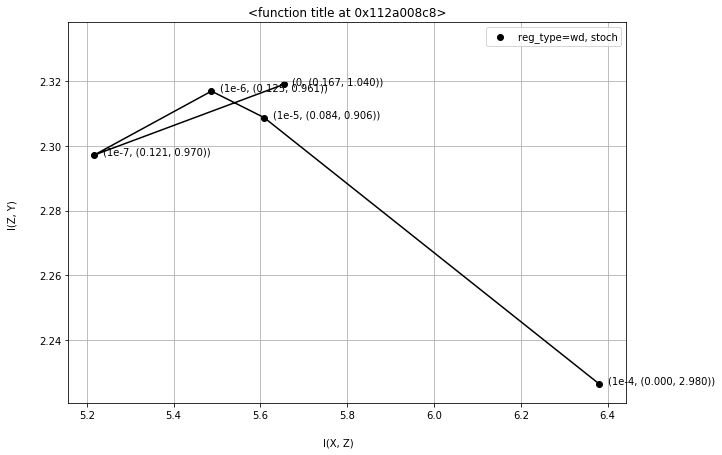

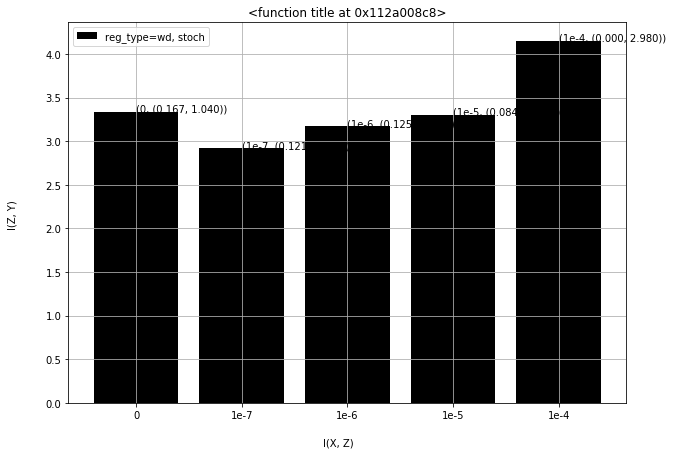

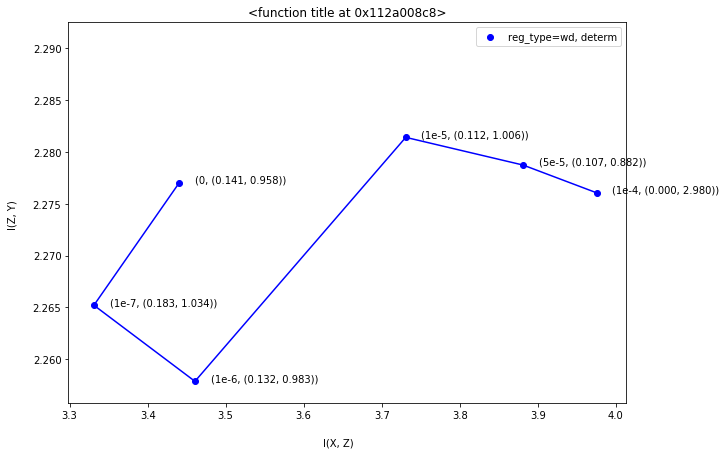

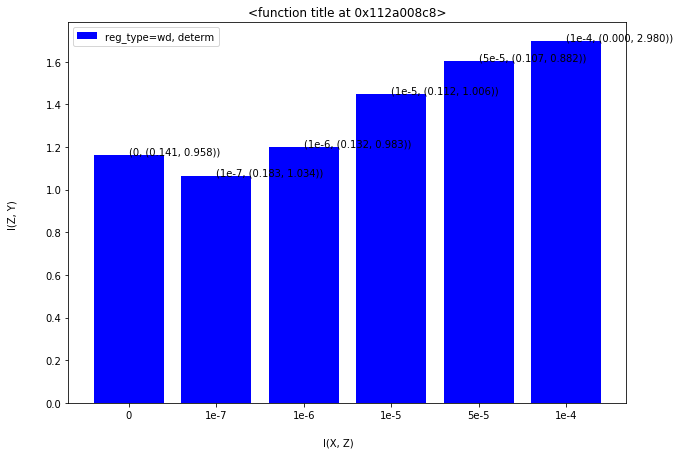

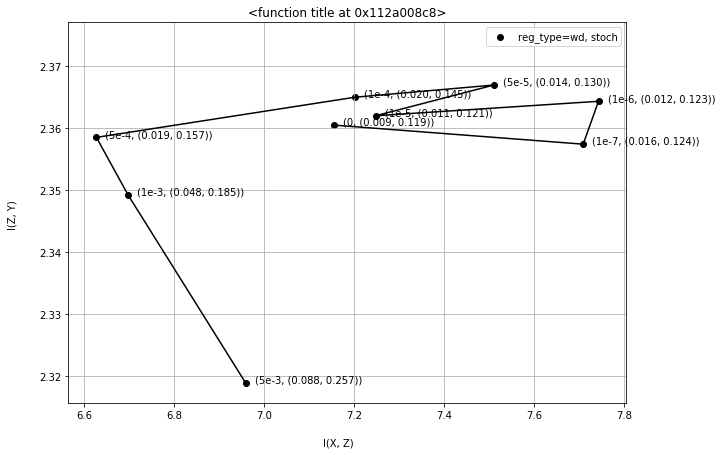

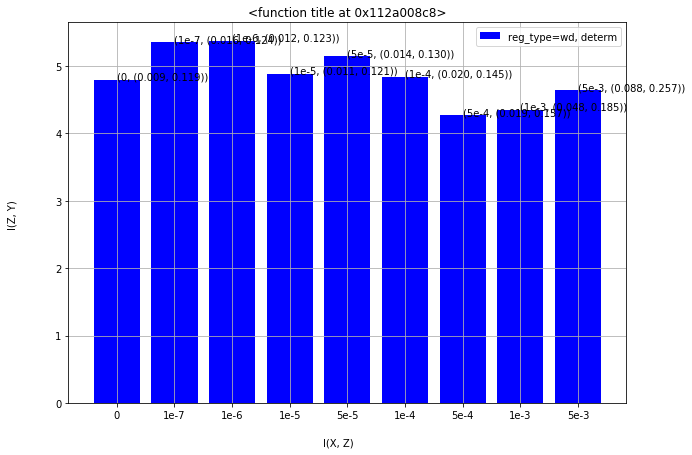

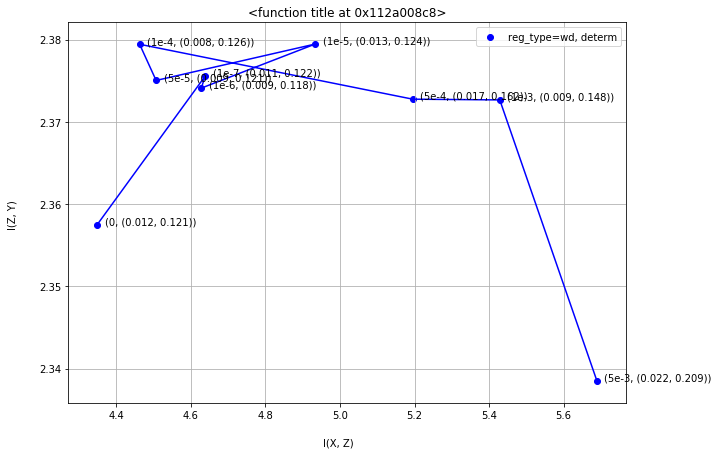

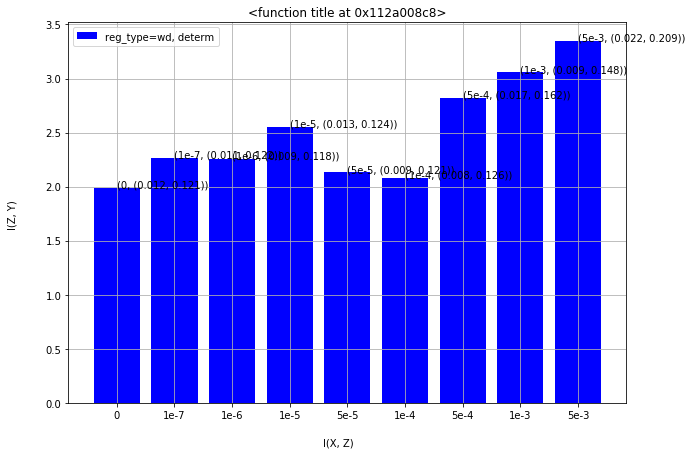

In [178]:
#Weight decay and dropout 
layers = [2]#[0, 1, 2]
colors = get_colors(4)
col = {'wd':colors[0], 'dout':colors[1], 'vib':colors[2], 'ceb':colors[3]}
# wd_vals = ['0', '1e-7', '1e-6', '75e-6', '1e-5', '5e-5', '1e-4', '5e-4', '1e-3', '5e-3', '1e-2', '5e-2']
wd_vals = ['0', '1e-7', '1e-6', '1e-5', '5e-5', '1e-4', '5e-4', '1e-3', '5e-3']#, '1e-2', '5e-2']


wd_abc = make_abc_df(wd_vals, 'cifar10', layers, 'wd', comment='stoch')
wd_mie = make_mie_df(wd_vals, 'cifar10', layers, 'wd', comment='stoch')
wd_abc = wd_abc.drop(index='5e-5')
wd_mie = wd_mie.drop(index='5e-5')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(wd_mie, 'cifar10', wd_abc, 'wd', fig, ax, c=col['wd'], title=cifar10_title, comment='stoch')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(wd_mie, 'cifar10', wd_abc, 'wd', fig, ax, folder='gap', c=col['wd'], title=cifar10_title, comment='stoch')
del(wd_abc)
del(wd_mie)

wd_abc = make_abc_df(wd_vals, 'cifar10', layers, 'wd', comment='determ')
wd_mie = make_mie_df(wd_vals, 'cifar10', layers, 'wd', comment='determ')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(wd_mie, 'cifar10', wd_abc, 'wd', fig, ax, c=col['dout'], title=cifar10_title, comment='determ')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(wd_mie, 'cifar10', wd_abc, 'wd', fig, ax, folder='gap', c=col['dout'], title=cifar10_title, comment='determ')
del(wd_abc)
del(wd_mie)

wd_abc = make_abc_df(wd_vals, 'mnist12k', layers, 'wd', comment='stoch')
wd_mie = make_mie_df(wd_vals, 'mnist12k', layers, 'wd', comment='stoch')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(wd_mie, 'mnist12k', wd_abc, 'wd', fig, ax, c=col['wd'], title=mnist12k_title, comment='stoch')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(wd_mie, 'cifar10', wd_abc, 'wd', fig, ax, folder='gap', c=col['dout'], title=mnist12k_title, comment='stoch')
del(wd_abc)
del(wd_mie)


wd_abc = make_abc_df(wd_vals, 'mnist12k', layers, 'wd', comment='determ')
wd_mie = make_mie_df(wd_vals, 'mnist12k', layers, 'wd', comment='determ')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(wd_mie, 'mnist12k', wd_abc, 'wd', fig, ax, c=col['dout'], title=mnist12k_title, comment='determ')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(wd_mie, 'cifar10', wd_abc, 'wd', fig, ax, folder='gap', c=col['dout'], title=mnist12k_title, comment='determ')

/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:76: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:77: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:32: 

MIE experiment for stoch with dout (0.45) is missing
MIE experiment for stoch with dout (0.6) is missing
MIE experiment for stoch with dout (0.75) is missing
                                             2
0       (8.70040597409548, 2.2636571916951986)
0.1     (8.018866675807981, 2.273020681978859)
0.2      (8.20361905250341, 2.283794878704822)
0.325  (6.558202477289117, 2.2088749170620305)
0.4    (6.158016605363612, 2.2615783715525453)
0.475  (6.186517700827189, 2.2504256187601537)
(0.13807357862619582, 1.0021055257407294)
(0.14451110508347054, 0.9770589270114994)
(0.1425240060820922, 1.1409462793108751)
(0.13899322526294974, 1.1200641295416605)
(0.12555524625650974, 1.1300703665975311)
(0.13228823365452794, 1.353910702318348)
saved information plane
(0.13807357862619582, 1.0021055257407294)
(0.14451110508347054, 0.9770589270114994)
(0.1425240060820922, 1.1409462793108751)
(0.13899322526294974, 1.1200641295416605)
(0.12555524625650974, 1.1300703665975311)
(0.13228823365452794, 1.353910

/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


MIE experiment for stoch with dout (0.4) is missing
MIE experiment for stoch with dout (0.475) is missing
                                             2
0        (9.08205829298213, 2.302764648549139)
0.1    (8.548473922799504, 2.3007989878692325)
0.2    (8.710162265683932, 2.3004726663965083)
0.325   (8.426730255091941, 2.299172791765321)
0.45   (8.547747618811474, 2.3009254744388747)
0.6     (8.623024655301421, 2.299825108943004)
0.75   (7.793144441161837, 2.2867883713661667)
(0.008552713721807697, 0.11934385353197807)
(0.02031663481936061, 0.13596019754163718)
(0.024873085039728886, 0.14145574093647972)
(0.036883910939726816, 0.15152546521843574)
(0.04437188156686908, 0.16453540967404126)
(0.04505115575208647, 0.17507118859528464)
(0.21486807649405226, 0.4993974139757082)
saved information plane
(0.008552713721807697, 0.11934385353197807)
(0.02031663481936061, 0.13596019754163718)
(0.024873085039728886, 0.14145574093647972)
(0.036883910939726816, 0.15152546521843574)
(0.0443718815668

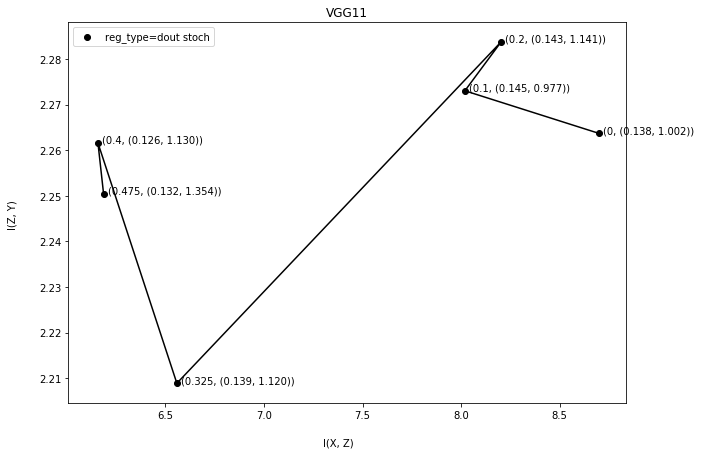

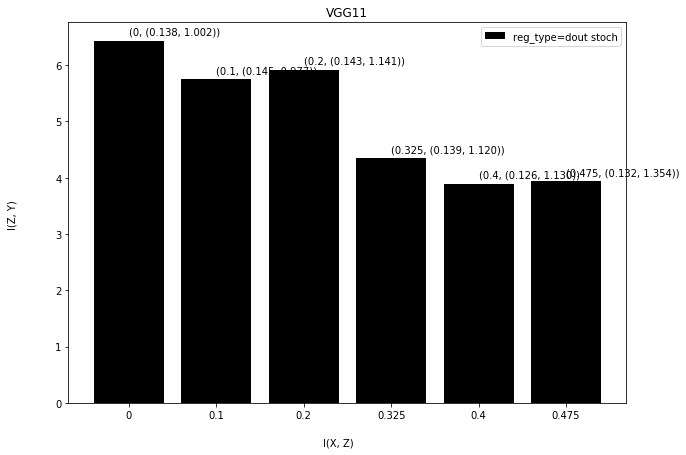

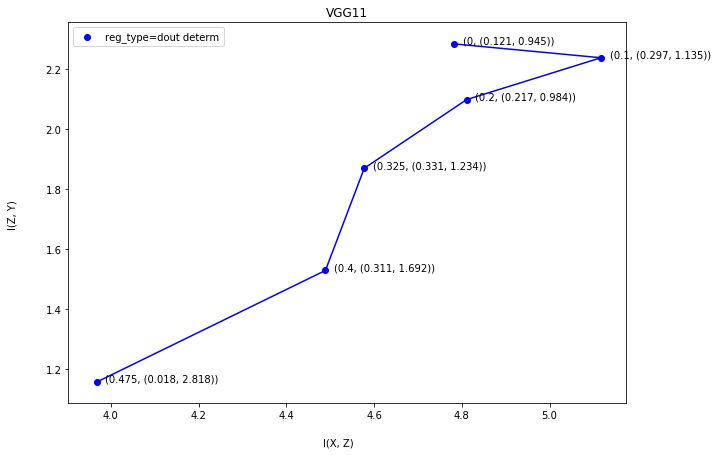

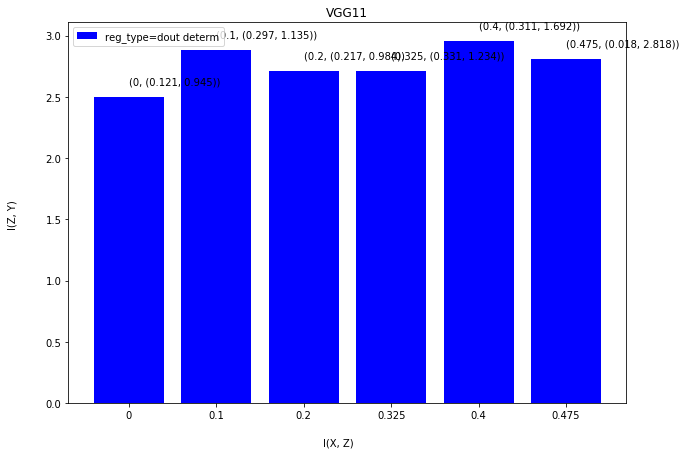

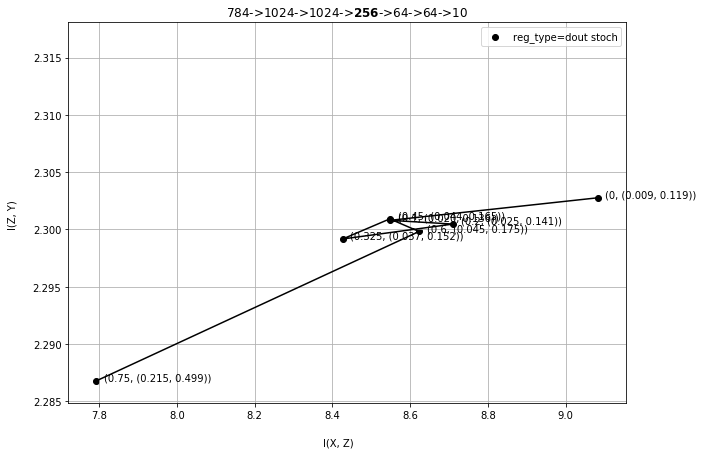

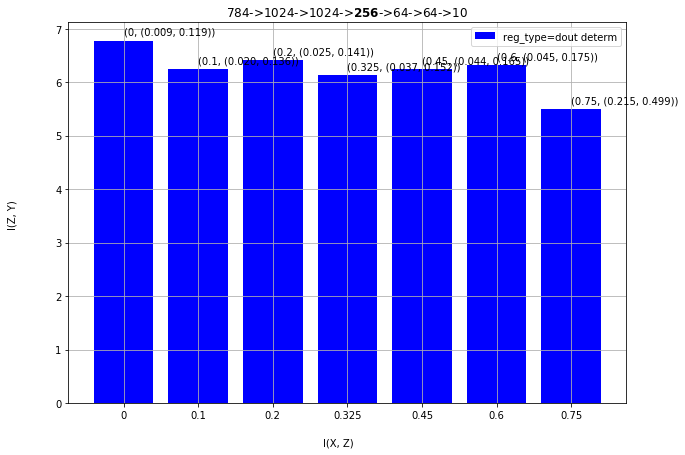

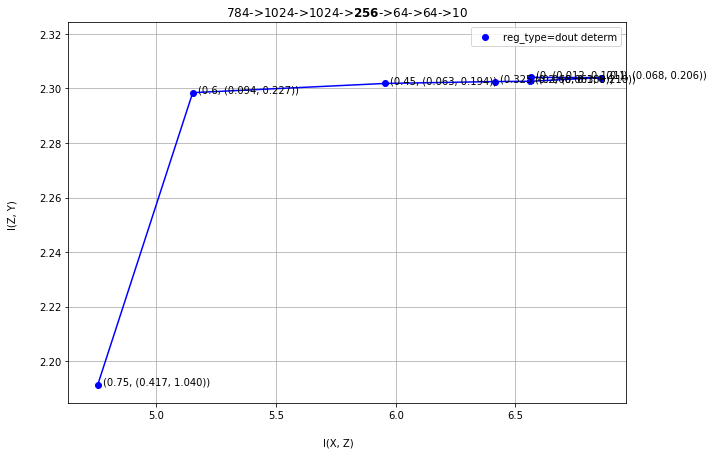

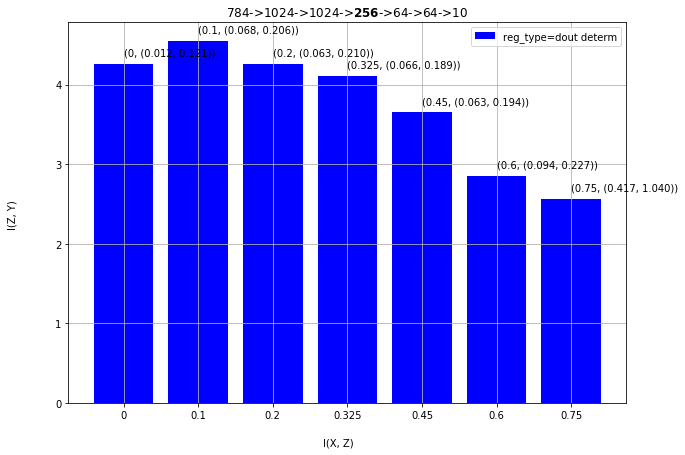

In [182]:
#Dropout 
layers = [2]#[0, 1, 2]
colors = get_colors(4)
col = {'wd':colors[0], 'dout':colors[1], 'vib':colors[2], 'ceb':colors[3]}

do_vals = ['0', '0.1', '0.2', '0.325', '0.4', '0.45', '0.475', '0.6', '0.75'] 

do_abc = make_abc_df(do_vals, 'cifar10', layers, 'dout', comment='stoch')
do_mie = make_mie_df(do_vals, 'cifar10', layers, 'dout', comment='stoch')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(do_mie, 'cifar10', do_abc, 'dout', fig, ax, c=col['wd'], title=cifar10_title, comment='stoch')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(do_mie, 'cifar10', do_abc, 'dout', fig, ax, folder='gap', c=col['wd'], title=cifar10_title, comment='stoch')
del(do_abc)
del(do_mie)

do_abc = make_abc_df(do_vals, 'cifar10', layers, 'dout', comment='determ')
do_mie = make_mie_df(do_vals, 'cifar10', layers, 'dout', comment='determ')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(do_mie, 'cifar10', do_abc, 'dout', fig, ax, c=col['dout'], title=cifar10_title, comment='determ')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(do_mie, 'cifar10', do_abc, 'dout', fig, ax, folder='gap', c=col['dout'], title=cifar10_title, comment='determ')
del(do_abc)
del(do_mie)

do_abc = make_abc_df(do_vals, 'mnist12k', layers, 'dout', comment='stoch')
do_mie = make_mie_df(do_vals, 'mnist12k', layers, 'dout', comment='stoch')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(do_mie, 'mnist12k', do_abc, 'dout', fig, ax, c=col['wd'], title=mnist12k_title, comment='stoch')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(do_mie, 'mnist12k', do_abc, 'dout', fig, ax, folder='gap', c=col['dout'], title=mnist12k_title, comment='determ')
del(do_abc)
del(do_mie)


do_abc = make_abc_df(do_vals, 'mnist12k', layers, 'dout', comment='determ')
do_mie = make_mie_df(do_vals, 'mnist12k', layers, 'dout', comment='determ')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(do_mie, 'mnist12k', do_abc, 'dout', fig, ax, c=col['dout'], title=mnist12k_title, comment='determ')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(do_mie, 'mnist12k', do_abc, 'dout', fig, ax, folder='gap', c=col['dout'], title=mnist12k_title, comment='determ')


/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:76: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:77: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:32: 

MIE experiment for  with vib (1e-2) is missing
MIE experiment for  with vib (5e-2) is missing
MIE experiment for  with vib (1e-1) is missing
                                             2
0        (7.61392553688539, 2.283591407766139)
1e-8     (8.121399255653051, 2.28880367553585)
1e-7    (6.805568491664251, 2.294384815378744)
1e-6    (5.168762767144672, 2.291365798535737)
1e-5   (4.279155745226517, 2.2777798457329097)
5e-5    (3.883256635526932, 2.280430927535296)
1e-4   (3.7605422682883263, 2.273828227627538)
5e-4  (3.2732647248129685, 2.2472897575757442)
1e-3   (3.291549939066243, 2.2581444934035972)
5e-3   (3.141268636169229, 2.1881644558136744)
(0.15715511747634692, 1.0404623162432405)
(0.0883270172077418, 0.9572696666415428)
(0.07121677328419736, 0.9193841385972434)
(0.07130663073790418, 0.9166957902209664)
(0.06288215579424936, 0.9254173817703408)
(0.027687835911186332, 0.8279237001646347)
(0.10770070566868496, 0.9560568167890128)
(0.14104233644343442, 0.984130121609646)
(0.1637

/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


MIE experiment for  with vib (5e-5) is missing
MIE experiment for  with vib (5e-4) is missing
                                             2
0      (8.769414664866437, 2.3011744857496685)
1e-8   (6.538115320468233, 2.3005997150497786)
1e-7    (4.852139459534414, 2.303049332937077)
1e-6  (3.5697452766188067, 2.2953914862729254)
1e-5   (2.799700199292293, 2.2810504697925524)
1e-4   (2.600487202162308, 2.2804723191828966)
1e-3     (2.6685613929705, 2.2891642628917634)
5e-3  (2.7053283524773417, 2.2924238540610613)
1e-2    (2.626898230243294, 2.280270601482617)
5e-2   (2.4723056424941348, 2.278566625172659)
1e-1  (2.3585030429609244, 2.2690599580109128)
(0.01838715295915312, 0.14257725828832524)
(0.01753824837138019, 0.13765806692318108)
(0.015649345354587785, 0.1246159423610389)
(0.008967563158831508, 0.12300579312023173)
(0.00743486893590849, 0.12804807565060286)
(0.007930484720769534, 0.13929756658856576)
(0.019989053978078437, 0.17793684363900808)
(0.12929741033860806, 0.29667321863973

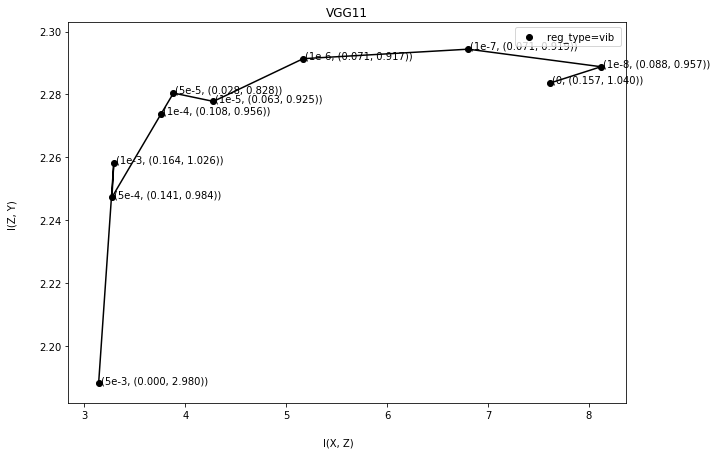

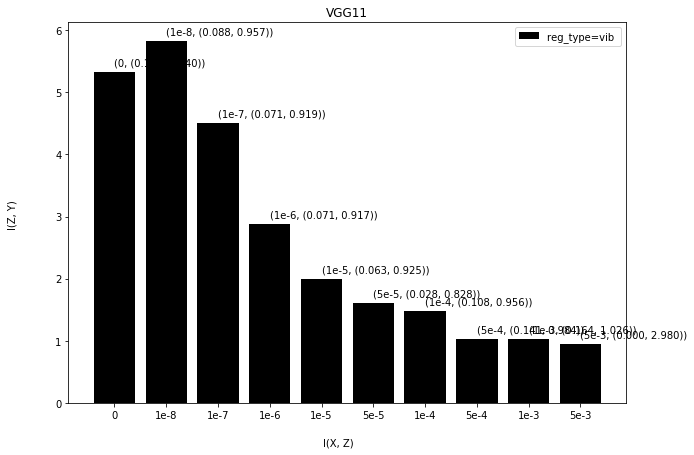

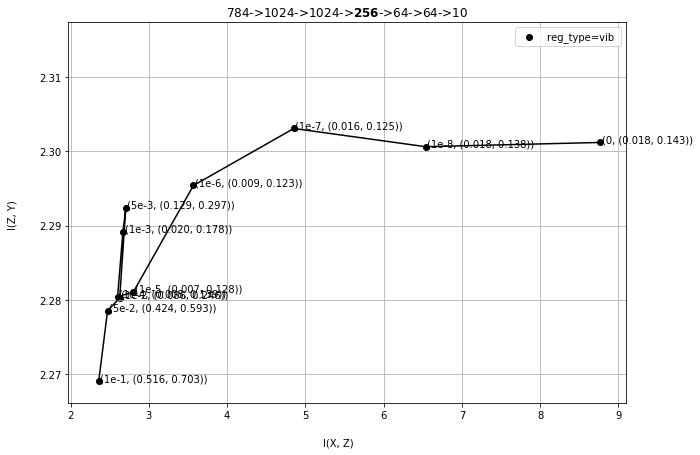

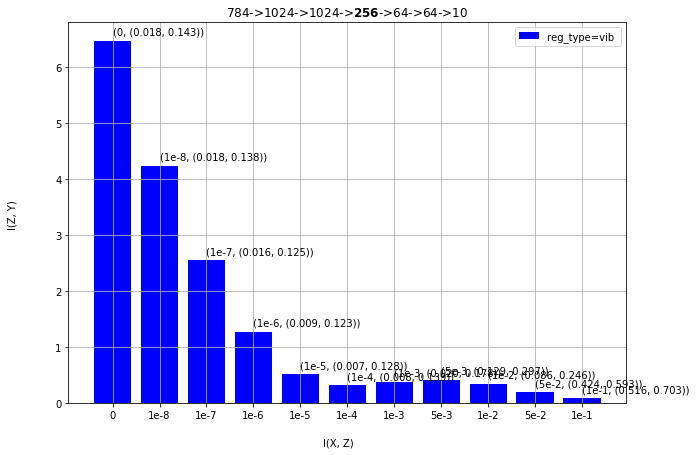

In [185]:
#VIB

layers = [2]
# ceb_vals = ['0', '1e-10', '1e-9', '1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '1e-2', '1e-1', '5e-1']#, '1e-0']
# ceb_vals = ['0', '1e-10', '1e-9', '1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '1e-2', '1e-1', '5e-1']#, '1e-0']
# ceb_vals = ['0', '1e-10', '1e-9', '1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '1e-2', '5e-2', '1e-1', '5e-1', '1', '5']

# ceb_vals = ['0', '1e-8', '1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '5e-3', '5e-3']#, '1e-2', '5e-2', '1e-1', '5e-1', '1', '5']

# cvib_vals = ['1e-7', '1e-6', '1e-5', '1e-4', '1e-3', '1e-2', '5e-2', '1e-1', '5e-1', '1', '5']

# vib_vals = ['0', '1e-8', '1e-7', '1e-6', '1e-5', '5e-5', '1e-4', '5e-4', '1e-3', '5e-3', '5875e-6', '1e-2', '5e-2', '1e-1', '5e-1', '1'] 
vib_vals = ['0', '1e-8', '1e-7', '1e-6', '1e-5', '5e-5', '1e-4', '5e-4', '1e-3', '5e-3', '1e-2', '5e-2', '1e-1']#, '5e-1', '1'] 

vib_abc = make_abc_df(vib_vals, 'cifar10', layers, 'vib')
vib_mie = make_mie_df(vib_vals, 'cifar10', layers, 'vib')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(vib_mie, 'cifar10', vib_abc, 'vib', fig, ax, c=col['wd'], title=cifar10_title)
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(vib_mie, 'cifar10', vib_abc, 'vib', fig, ax, folder='gap', c=col['wd'], title=cifar10_title)
del(vib_abc)
del(vib_mie)



vib_abc = make_abc_df(vib_vals, 'mnist12k', layers, 'vib')
vib_mie = make_mie_df(vib_vals, 'mnist12k', layers, 'vib')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(vib_mie, 'mnist12k', vib_abc, 'vib', fig, ax, c=col['wd'], title=mnist12k_title)
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(vib_mie, 'mnist12k', vib_abc, 'vib', fig, ax, folder='gap', c=col['dout'], title=mnist12k_title)
del(vib_abc)
del(vib_mie)

/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:72: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:76: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:77: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:32: 

MIE experiment for unit with ceb (1e-2) for cifar10 is missing
MIE experiment for unit with ceb (5e-2) for cifar10 is missing
MIE experiment for unit with ceb (1e-1) for cifar10 is missing
MIE experiment for unit with ceb (5e-1) for cifar10 is missing
MIE experiment for unit with ceb (1) for cifar10 is missing
                                            2
1e-5  (3.8332142757513346, 2.276479281191021)
5e-5  (3.327712958120836, 2.2731714026829457)
1e-4  (3.4800880811241024, 2.264643917350347)
5e-4  (3.298609888155125, 2.2544399635053667)
1e-3   (2.99408041996784, 2.2634155024473483)
5e-3    (2.79070595520613, 2.178717729881167)
saved information plane
saved information plane
MIE experiment for learnt with ceb (1e-2) for cifar10 is missing
MIE experiment for learnt with ceb (5e-2) for cifar10 is missing
MIE experiment for learnt with ceb (1e-1) for cifar10 is missing
MIE experiment for learnt with ceb (5e-1) for cifar10 is missing
MIE experiment for learnt with ceb (1) for cifar10 is miss

/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:73: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


MIE experiment for unit with ceb (5e-5) for mnist12k is missing
MIE experiment for unit with ceb (5e-4) for mnist12k is missing
                                             2
1e-5   (3.1621085087978646, 2.295712174588725)
1e-4  (2.3763718011998933, 2.3029046751227638)
1e-3    (2.360418114179655, 2.298483924290963)
5e-3   (2.371773478055285, 2.2958077348366595)
1e-2  (2.3834166117343627, 2.2898237618070754)
5e-2  (2.3694928734595826, 2.2901221401752947)
1e-1   (2.343815967691323, 2.2822259324150425)
5e-1   (2.287910050257803, 2.2232589672718728)
1     (1.9175714424512709, 1.8229950374293893)
GC experiment for unit with ceb (5e-1) is missing
GC experiment for unit with ceb (1) is missing
saved information plane
GC experiment for unit with ceb (5e-1) is missing
GC experiment for unit with ceb (1) is missing
saved information plane
MIE experiment for unit with ceb (5e-5) for mnist12k is missing
MIE experiment for unit with ceb (5e-4) for mnist12k is missing
                                

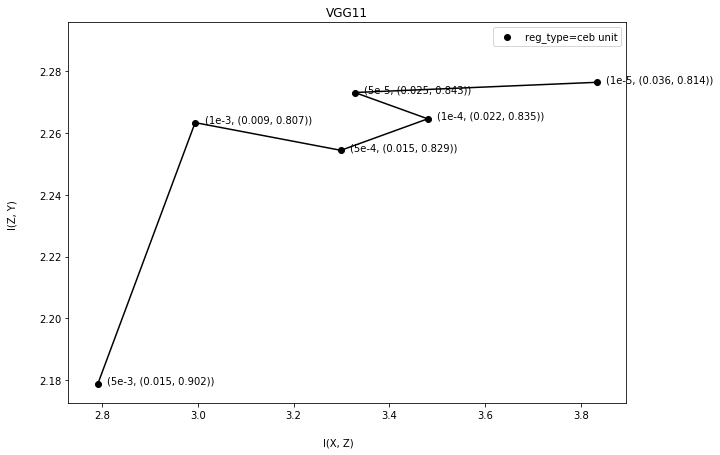

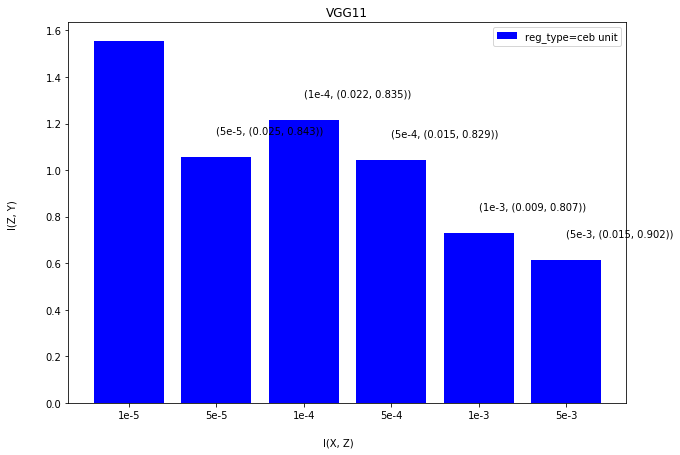

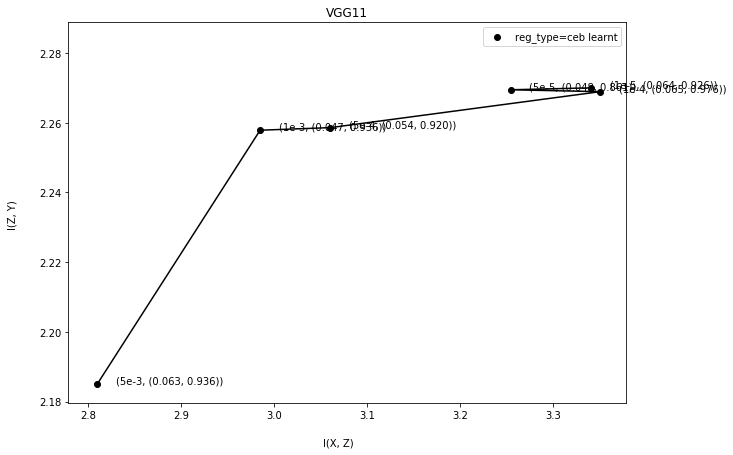

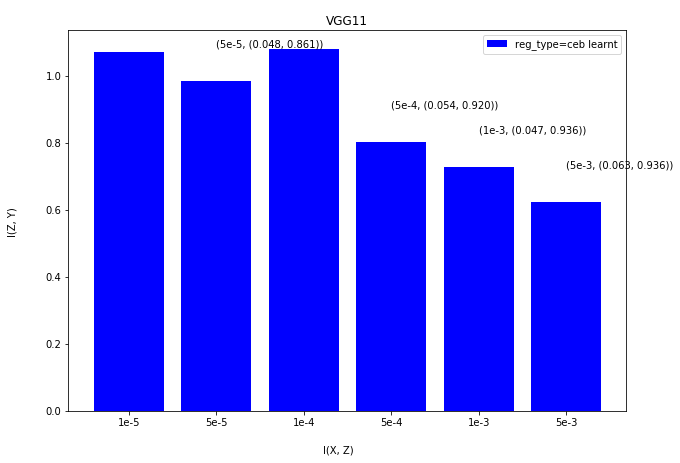

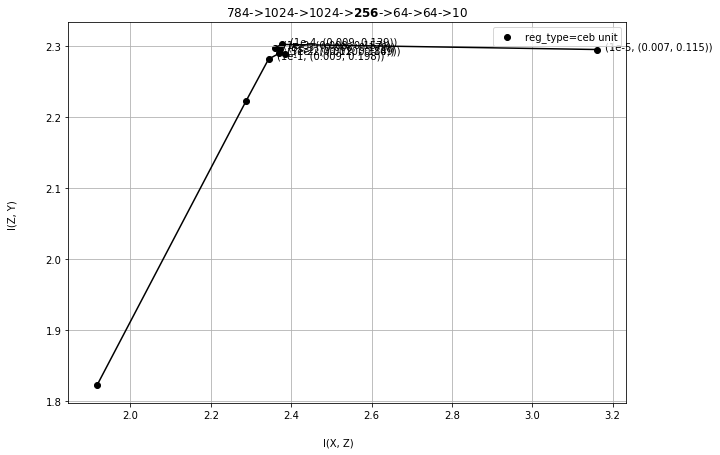

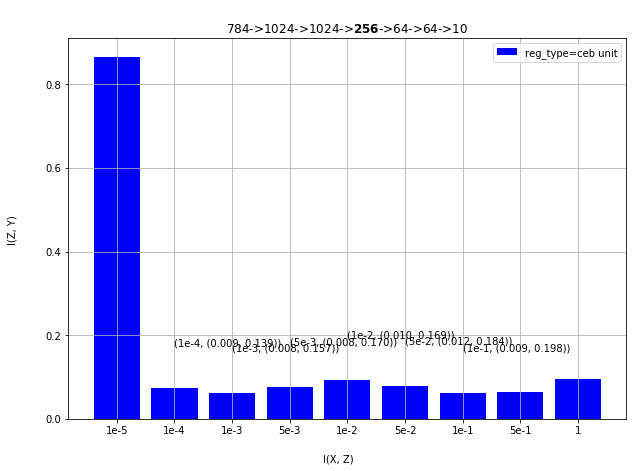

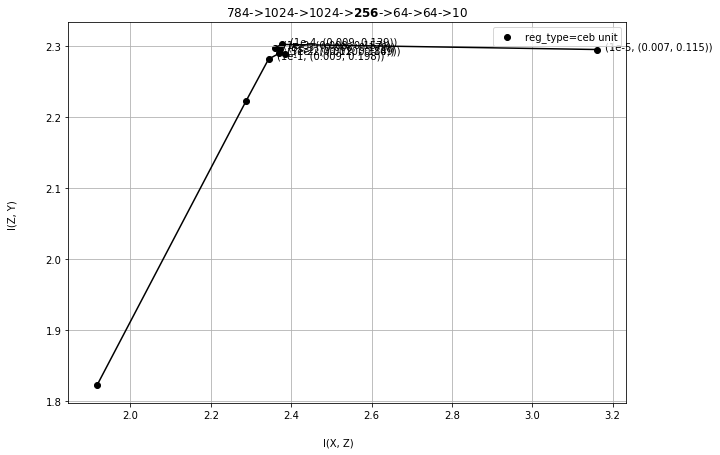

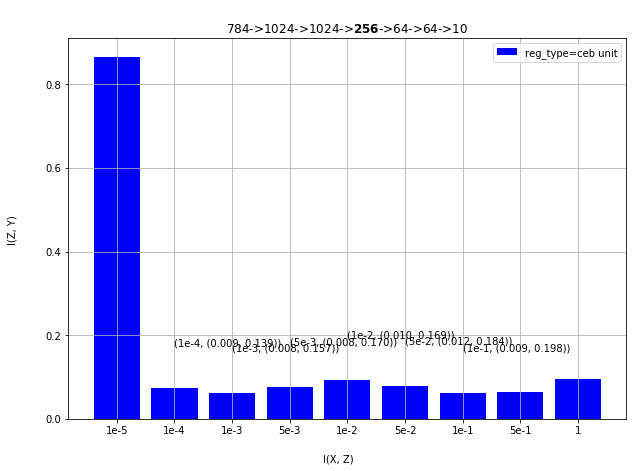

In [196]:
# CVIB

# cvib_vals = ['0', '1e-8', '1e-7', '1e-6', '1e-5', '5e-5', '1e-4', '5e-4', '1e-3', '5e-3', '1e-2', '5e-2', '1e-1']#, '5e-1', '1'] 
cvib_vals = ['1e-5', '5e-5', '1e-4', '5e-4', '1e-3', '5e-3', '1e-2', '5e-2', '1e-1', '5e-1', '1'] 


cvib_abc = make_abc_df(cvib_vals, 'cifar10', layers, 'ceb', comment='unit')
cvib_mie = make_mie_df(cvib_vals, 'cifar10', layers, 'ceb', comment='unit')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(cvib_mie, 'cifar10', cvib_abc, 'ceb', fig, ax, c=col['wd'], title=cifar10_title, comment='unit')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(cvib_mie, 'cifar10', cvib_abc, 'ceb', fig, ax, folder='gap', c=col['dout'], title=cifar10_title, comment='unit')
del(cvib_abc)
del(cvib_mie)

cvib_abc = make_abc_df(cvib_vals, 'cifar10', layers, 'ceb', comment='learnt')
cvib_mie = make_mie_df(cvib_vals, 'cifar10', layers, 'ceb', comment='learnt')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(cvib_mie, 'cifar10', cvib_abc, 'ceb', fig, ax, c=col['wd'], title=cifar10_title, comment='learnt')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(cvib_mie, 'cifar10', cvib_abc, 'ceb', fig, ax, folder='gap', c=col['dout'], title=cifar10_title, comment='learnt')
del(cvib_abc)
del(cvib_mie)

cvib_abc = make_abc_df(cvib_vals, 'mnist12k', layers, 'ceb', comment='unit')
cvib_mie = make_mie_df(cvib_vals, 'mnist12k', layers, 'ceb', comment='unit')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(cvib_mie, 'mnist12k', cvib_abc, 'ceb', fig, ax, c=col['wd'], title=mnist12k_title, comment='unit')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(cvib_mie, 'mnist12k', cvib_abc, 'ceb', fig, ax, folder='gap', c=col['dout'], title=mnist12k_title, comment='unit')
del(cvib_abc)
del(cvib_mie)


cvib_abc = make_abc_df(cvib_vals, 'mnist12k', layers, 'ceb', comment='unit')
cvib_mie = make_mie_df(cvib_vals, 'mnist12k', layers, 'ceb', comment='unit')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(cvib_mie, 'mnist12k', cvib_abc, 'ceb', fig, ax, c=col['wd'], title=mnist12k_title, comment='unit')
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
_ = information_plane(cvib_mie, 'mnist12k', cvib_abc, 'ceb', fig, ax, folder='gap', c=col['dout'], title=mnist12k_title, comment='unit')



KeyError: '0'

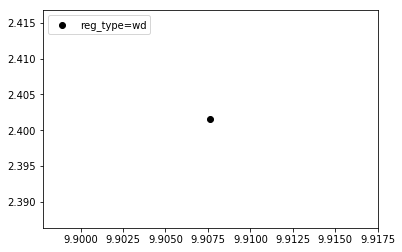

In [587]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)

fig, ax = information_plane(wd_mie, wd_abc, 'wd', fig, ax, col['wd'], 'allin1', 2, title=title)
fig, ax = information_plane(do_mie, do_abc, 'do', fig, ax, col['dout'], 'allin1', 2, title=title)
fig, ax = information_plane(vib_mie, vib_abc, 'vib', fig, ax, col['vib'], 'allin1', 2, title=title)
